In [1]:
# -*- coding: utf-8 -*
from random import seed
from tools import hio, util
from learning.LearnModel import Learn_Model, valid
from models.ChoiceModel import Choice_Model
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np

conf = util.parse_config()

2023-02-08 16:49:28.725314: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# image data
random_state = 10
DEFAULT_HEIGHT = 64
n_components = 64 * 6

#target data
Class = {
    'Malignant' : 0,
    'Benign' : 1
}

# learning setting
# model_name = 'vggLike_3DCNN'
# model_name = 'ResNetLike_3DCNN'
model_name = 'my_3DCNN'
# model_name = 'sample_3DCNN'

batch_size = 4
learningRate = 0.001
num_of_epoch = 300

In [3]:
x_train, x_test, y_train, y_test = hio.get_train_test_for_clasification(Class, height=DEFAULT_HEIGHT, n_components=n_components, is_split=True, show_image=True, random_state=random_state)

print(y_train)
print(y_test)
print(sum(y_train==0), sum(y_train==1))
print(sum(y_test==0), sum(y_test==1))

train IDs: ['321' '230' '157' '160' '233' '342' '251' '236' '308' '163' '348' '199'
 '290' '227' '333' '361' '215' '324' '263' '266' '150' '260' '181' '218'], test IDs: ['212' '187' '284']
image data size (309, 64, 64, 401)
label size (309,)
xtrain:  309 , xtest:  19 ytrain:  309 , ytest:  19
[0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
226 83
11 8


In [4]:
class medHSI_Dataset(Dataset):
    def __init__(self, images, targets, transform, n_components=10):
        self.images = images
        self.targets = targets
        self.transform = transform
        self.n_components = n_components
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        original_image = self.images[index]
        image = self.transform(original_image)
        image = self.decompose(image, n_components=self.n_components)
        image = image.view(1, image.size(0),image.size(1),image.size(2))
        
        target = self.targets[index]
        
        dataset = {'image': image, 'target': target, 'original_image': original_image}
        
        return dataset
        
    def show_montage_dataset(self, channel=401, name='train'):
        from tools import util
        util.show_montage(self.images, channel=channel, savename=name+'_montage.jpg')
    
    def decompose(self, hsi, n_components=10):
        numDecom = hsi.shape[0] - n_components
        decom_hsi = hsi[numDecom//2:numDecom//2+n_components, :, :]
        
        return decom_hsi

In [5]:
target_class = list(Class.values())

originalTransform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tuple(util.Average_for_hsiList(x_train)), tuple(util.Std_for_hsiList(x_train)))])

train_dataset = medHSI_Dataset(x_train, y_train, transform=originalTransform, n_components=n_components)
train_dataset.show_montage_dataset(channel=401, name='train')
test_dataset = medHSI_Dataset(x_test, y_test, transform=originalTransform, n_components=n_components)
test_dataset.show_montage_dataset(channel=401, name='test')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [7]:
n = 5

r = []

for i in range(n):
    model = Choice_Model(model_name, train_dataset[0]['image'], target_class).to(torch.float).to(device)
    if device == 'cuda':
        model = torch.nn.DataParallel(model) # make parallel
        torch.backends.cudnn.benchmark = True
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learningRate, momentum=0.9)
    
    model, result = Learn_Model(train_dataloader, test_dataloader, model, num_of_epoch, criterion, optimizer, device)
    
    r.append([result['train']['loss'][-1], result['train']['acc'][-1], result['test']['loss'][-1], result['test']['acc'][-1]])

epoch 59, train loss: 0.5811 , train_acc: 0.7314, val_loss: 0.7471 val_acc: 0.5789
epoch 119, train loss: 0.1357 , train_acc: 0.9547, val_loss: 2.5022 val_acc: 0.4737
epoch 179, train loss: 0.0001 , train_acc: 1.0000, val_loss: 10.4277 val_acc: 0.4737
epoch 239, train loss: 0.0000 , train_acc: 1.0000, val_loss: 11.1563 val_acc: 0.4737
epoch 299, train loss: 0.0000 , train_acc: 1.0000, val_loss: 11.9686 val_acc: 0.4737
epoch 59, train loss: 0.5795 , train_acc: 0.7314, val_loss: 0.7485 val_acc: 0.5789
epoch 119, train loss: 0.3351 , train_acc: 0.8900, val_loss: 0.8416 val_acc: 0.5263
epoch 179, train loss: 0.0472 , train_acc: 0.9871, val_loss: 3.6635 val_acc: 0.5263
epoch 239, train loss: 0.0001 , train_acc: 1.0000, val_loss: 7.8803 val_acc: 0.6316
epoch 299, train loss: 0.0000 , train_acc: 1.0000, val_loss: 9.5439 val_acc: 0.6316
epoch 59, train loss: 0.5896 , train_acc: 0.7314, val_loss: 0.7267 val_acc: 0.5789
epoch 119, train loss: 0.1632 , train_acc: 0.9450, val_loss: 1.5756 val_acc:

In [8]:
for i in range(n):
    print(r[i])

[1.1612861990729383e-05, 1.0, 11.968613624572754, 0.47368421052631576]
[1.9465917486190148e-05, 1.0, 9.543890571594238, 0.631578947368421]
[2.118653251840896e-05, 1.0, 7.4320932745933534, 0.47368421052631576]
[1.2337587678487512e-05, 1.0, 9.768510723114014, 0.42105263157894735]
[1.65245897413604e-05, 1.0, 5.410123872756958, 0.47368421052631576]


In [9]:
# train_loss, train_acc, train_Correct_Data, train_False_Data = valid(model, train_dataloader, criterion, device, is_test=True)

In [10]:
'''
print(len(train_Correct_Data))
if len(train_Correct_Data) != 0:
    print(train_Correct_Data[0].shape)
    
print(len(train_False_Data))
if len(train_False_Data) != 0:
    print(train_False_Data[0].shape)
'''

'\nprint(len(train_Correct_Data))\nif len(train_Correct_Data) != 0:\n    print(train_Correct_Data[0].shape)\n    \nprint(len(train_False_Data))\nif len(train_False_Data) != 0:\n    print(train_False_Data[0].shape)\n'

In [11]:
'''
if len(train_Correct_Data) != 0:
    util.show_montage(train_Correct_Data, channel=401, savename='train_Correct_Data_montage.jpg')

if len(train_False_Data) != 0:
    util.show_montage(train_False_Data, channel=401, savename='train_False_Data_montage.jpg')
'''

"\nif len(train_Correct_Data) != 0:\n    util.show_montage(train_Correct_Data, channel=401, savename='train_Correct_Data_montage.jpg')\n\nif len(train_False_Data) != 0:\n    util.show_montage(train_False_Data, channel=401, savename='train_False_Data_montage.jpg')\n"

In [12]:
val_loss, val_acc, Correct_Data, False_Data = valid(model, test_dataloader, criterion, device, is_test=True)

correct: tensor([ True, False,  True, False], device='cuda:0'), target: tensor([0, 1, 0, 1], device='cuda:0'), pred: tensor([0, 0, 0, 0], device='cuda:0')
outputs: tensor([[ 0.6765, -0.5570],
        [ 6.7922, -6.5696],
        [ 5.6427, -5.3705],
        [ 6.3813, -5.8356]], device='cuda:0')
loss: 6.458613395690918, running_loss: 6.458613395690918
total correct: 2, total: 4
correct: tensor([False,  True, False,  True], device='cuda:0'), target: tensor([1, 0, 0, 0], device='cuda:0'), pred: tensor([0, 0, 1, 0], device='cuda:0')
outputs: tensor([[ 7.8652, -7.3604],
        [ 1.9748, -1.8417],
        [-5.5405,  5.2587],
        [ 2.0823, -1.8511]], device='cuda:0')
loss: 6.516514301300049, running_loss: 12.975127696990967
total correct: 4, total: 8
correct: tensor([False, False, False, False], device='cuda:0'), target: tensor([0, 0, 1, 1], device='cuda:0'), pred: tensor([1, 1, 0, 0], device='cuda:0')
outputs: tensor([[-2.2924,  2.1935],
        [-2.5636,  2.5403],
        [ 9.0662, -8.64

In [13]:
print(len(Correct_Data))
if len(Correct_Data) != 0:
    print(Correct_Data[0].shape)
    
print(len(False_Data))
if len(False_Data) != 0:
    print(False_Data[0].shape)

9
(64, 64, 401)
10
(64, 64, 401)


In [14]:
if len(Correct_Data) != 0:
    util.show_montage(Correct_Data, channel=401, savename='Correct_Data_montage.jpg')

if len(False_Data) != 0:
    util.show_montage(False_Data, channel=401, savename='False_Data_montage.jpg')

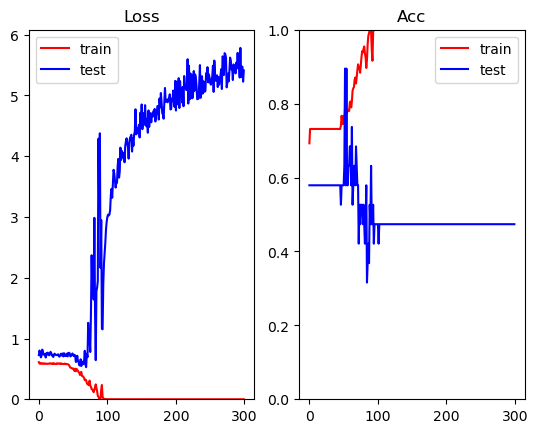

In [15]:
x = np.arange(num_of_epoch)

loss_max = max(max(result['train']['loss'], result['test']['loss'], key=max))

plt.subplot(1, 2, 1, title='Loss')
plt.plot(x, result['train']['loss'], color='red', label='train')
plt.plot(x, result['test']['loss'], color='blue', label='test')
plt.ylim(0, loss_max+0.3)
plt.legend()

plt.subplot(1, 2, 2, title='Acc')
plt.plot(x, result['train']['acc'], color='red', label='train')
plt.plot(x, result['test']['acc'], color='blue', label='test')
plt.ylim(0, 1)

plt.legend()

filename = os.path.join(conf['Directories']['outputDir'], 'T20211207-python', '学習曲線.png')
plt.savefig(filename)

plt.show()

In [16]:
from torchinfo import summary

summary(model=model, input_size=(batch_size, 1, n_components, DEFAULT_HEIGHT, DEFAULT_HEIGHT))

Layer (type:depth-idx)                   Output Shape              Param #
my_3DCNN                                 [4, 2]                    --
├─Sequential: 1-1                        [4, 64, 6, 64, 64]        --
│    └─Conv3d: 2-1                       [4, 2, 384, 64, 64]       16
│    └─MaxPool3d: 2-2                    [4, 2, 192, 64, 64]       --
│    └─ReLU: 2-3                         [4, 2, 192, 64, 64]       --
│    └─Conv3d: 2-4                       [4, 4, 192, 64, 64]       60
│    └─MaxPool3d: 2-5                    [4, 4, 96, 64, 64]        --
│    └─ReLU: 2-6                         [4, 4, 96, 64, 64]        --
│    └─Conv3d: 2-7                       [4, 8, 96, 64, 64]        168
│    └─MaxPool3d: 2-8                    [4, 8, 48, 64, 64]        --
│    └─ReLU: 2-9                         [4, 8, 48, 64, 64]        --
│    └─Conv3d: 2-10                      [4, 16, 48, 64, 64]       656
│    └─MaxPool3d: 2-11                   [4, 16, 24, 64, 64]       --
│    └─ReLU: 